## Lending Club Modeling

Objective: create model to predict defaults with Lending Club dataset
    - Initial data exploration was done in the "lending_club_exploration" notebook
    - Default is considered as either a loan status of "Default" or "Charged Off" - reflected in the "isedfault" attribute
    - The data was lightly processed in the exploration notebook with basic data conversions but no outlier replacements, encodings, etc. was done. It will be done here with pipelines

- Data dimensionality is reduced with Factor Analysis of Mixed Data Types
- Comparing quality across multiple models

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import sklearn 
sklearn.__version__

'0.20.3'

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore', 'lbfgs failed to converge*')
warnings.filterwarnings('ignore', 'Data with input dtype int64*')
warnings.filterwarnings('ignore', 'The default value*')

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import RFECV

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, Binarizer, LabelBinarizer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
import prince

In [7]:
#importing the df:

#%store -r df
df = pd.read_csv('df.csv')

In [8]:
#df = df.select_dtypes(include=['int', 'float'])

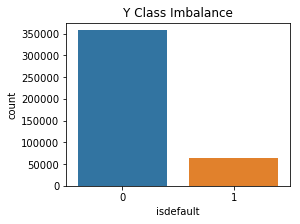

In [9]:
#Target Class Analsys:

#The target class isdefault is highly imbalanced:

#df.isdefault.value_counts()

fig, ax = plt.subplots(figsize=(4,3))
sns.countplot(x="isdefault", data=df)
plt.title('Y Class Imbalance')
plt.show()

In [10]:
#Do imputation analysis on 
df[df.columns[df.isnull().sum()>0]].isnull().sum().sort_values(ascending=False)
#potentially create a feature from the mths since last attribtues

mths_since_last_record    346680
mths_since_last_delinq    203962
mths_since_recent_inq      44599
emp_title                  23874
emp_length                 23817
mo_sin_old_il_acct         12254
percent_bc_gt_75            4239
mths_since_recent_bc        3798
revol_util                   162
title                        132
dti                            2
num_rev_accts                  1
dtype: int64

In [11]:
#X.fillna(X.mean(),inplace=True)

In [12]:
numeric_features = list(df.select_dtypes(include=['int', 'float']).columns)
numeric_features.remove('isdefault')

In [13]:
categorical_features = list(df.select_dtypes(include='object').columns)

In [14]:
df = df.iloc[:1000,:]

In [15]:
y = df['isdefault']
X = df.drop('isdefault', axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

In [17]:
#New Model

In [44]:
numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))
        #('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent'))
        #('onehot', OneHotEncoder(handle_unknown='ignore'))])  
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        #('bin', binary_transformer, bin_features), 
        #('lab_bin', label_binary_transformer, lab_bin_features) 
    ], 
        #setting remainder to passthrough so features that are not included are not dropped
        remainder='passthrough')

In [45]:
pipe = Pipeline(steps=[('preprocessor', preprocessor)])

In [54]:
temp_df = pipe.fit(X_train,y_train).transform(X_train)

In [55]:
famd = prince.FAMD(n_iter=3,copy=True,check_input=True,engine='fbpca',random_state=42)

In [57]:
famd.fit(temp_df)

ValueError: FAMD works with categorical and numerical data but you only have categorical data; you should consider using MCA

In [50]:
pd.DataFrame(temp_df)

ValueError: DataFrame constructor not properly called!

In [51]:
type(temp_df)

sklearn.pipeline.Pipeline

In [30]:
numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))
        #('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent'))
        #('onehot', OneHotEncoder(handle_unknown='ignore'))])  
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        #('bin', binary_transformer, bin_features), 
        #('lab_bin', label_binary_transformer, lab_bin_features) 
    ], 
        #setting remainder to passthrough so features that are not included are not dropped
        remainder='passthrough')
    
famd = prince.FAMD(n_iter=3,copy=True,check_input=True,engine='fbpca',random_state=42)
    
bc = BaggingClassifier(random_state=1)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipe = Pipeline(steps=[('preprocessor', preprocessor),('pca', famd),('clf', bc)])

In [31]:
param_grid = {'pca__n_components':[8,12,16], 'clf__n_estimators':[5,10], 'clf__max_samples':[100,500,1000]}

In [32]:
search = GridSearchCV(pipe, param_grid, iid=False, cv=5)

In [33]:
search.fit(X_train, y_train)

/Applications/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: FAMD works with categorical and numerical data but you only have categorical data; you should consider using MCA

In [ ]:
search.score(X_test, y_test)

0.8400446453308424

In [ ]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.843):
{'clf__max_samples': 1000, 'clf__n_estimators': 10, 'pca__n_components': 8}


In [ ]:
cv_metric = cross_val_score(search, X_train, y_train, cv=3)

In [ ]:
print("Training {} Mean with CV: {}".format('accuracy', cv_metric.mean()))
print("Training {} Standard Dev with CV: {}".format('accuracy', cv_metric.std()))
print("Test Score: %.3f" % search.score(X_test, y_test))

In [ ]:
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ClassificationReport, PrecisionRecallCurve, ConfusionMatrix

In [ ]:
models_report = pd.DataFrame(cv_metric, columns=['CLF'])

In [ ]:
fig, ax1 = plt.subplots(figsize=(len(models_report.columns)*3,4))
sns.boxplot(data=models_report, ax=ax1)
plt.suptitle('Model Evaluation Report')
plt.show()

In [ ]:
search.best_estimator_.named_steps['clf']

In [ ]:
search.best_estimator_

Model Evaluation

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

cr_best = ClassificationReport(search.best_estimator_, ax=ax, classes=['1', '0'])
cr_best.fit(X_train, y_train)
cr_best.score(X_test, y_test)

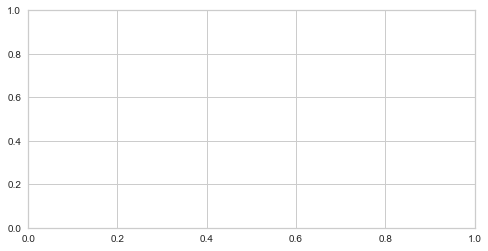

In [74]:
fig, ax = plt.subplots(figsize=(8,4))

viz_vc_bg = ValidationCurve(
    search.best_estimator_, param_name="clf__n_estimators",
    param_range=[5,7,9,11,13,15], cv=3, scoring="accuracy", ax=ax)

viz_vc_bg.fit(X_train, y_train)

ax.set(title='Validation Curves for GBM', xlabel='Learning Rate', ylabel='Score')
ax.legend().set_visible(True)

viz_vc_bg.poof()

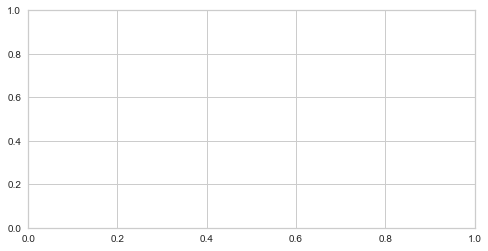

In [75]:
fig, ax = plt.subplots(figsize=(8,4))

viz_lc_bg = LearningCurve(search.best_estimator_, train_sizes = np.linspace(0.1, 1.0, 10), cv=3, ax=ax)

# Fit and poof the visualizer
viz_lc_bg.fit(X_train, y_train)

ax.set(title='Learning Curves for GBM', xlabel='Training Instances', ylabel='Score')

ax.legend().set_visible(True)

viz_lc_bg.poof()

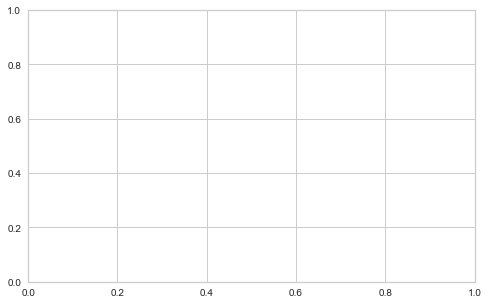

In [77]:
fig, ax = plt.subplots(figsize=(8,5))

cm_bg = ConfusionMatrix(search.best_estimator_, classes=[0,1], ax=ax)
cm_bg.fit(X_train, y_train)
cm_bg.score(X_test, y_test)

ax.set(title='GBM Confusion Matrix', xlabel='Predicted Class', ylabel='True Class')

cm_bg.poof()

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [11]:
#Checking that all types have been accounted for:
#df.dtypes.unique()

In [19]:
#This calls for a variety of approaches:

#1. we can try upsampling the minority class
#2. we can use ensemble methods that leverage stratified sampling in order to deal with the imbalance

In [20]:
#Trying without upsampling first:

In [21]:
#Creating attribute lists for scikit learn pipelines:
numeric_features = list(df.select_dtypes(include=['int', 'float']).columns)
#cat_features = list(df.select_dtypes(include=['object']).columns)
#remove binary variables from here or they will be scaled

In [22]:
numeric_features.remove('isdefault')

In [23]:
#will break
#df = pd.get_dummies(df, columns=cat_features, drop_first=True)

In [24]:
#Models to be evaluated - can be modified/overridden to include more
def models():
    models = {}
    models['log'] = (LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=1), {'C':[0.01, 0.1, 1]})
    #models['ridge'] = (RidgeClassifier(class_weight='balanced', random_state=1), {'alpha':[0.01, 0.1, 1]})
    #models['svc'] = (SVC(class_weight='balanced'), {'C':[0.1, 1], 'gamma':['auto']})
    #models['ada'] = (AdaBoostClassifier(random_state=1), {'learning_rate':[0.5, 1]})
    #models['gbm'] = (GradientBoostingClassifier(random_state=1), {'learning_rate':[0.5, 1]})
    #models['gaus_nb'] = (GaussianNB(), {'var_smoothing':[1e-9, 1]})
    
    #models['bagging_class'] = (BaggingClassifier(random_state=1), {'n_estimators':[7,12], 'max_samples':[1,5]})
    #models['rf_class'] = (RandomForestClassifier(class_weight='balanced', random_state=1), {'max_depth':[100, 1000], 'max_leaf_nodes':[10, 20, 30]})
    
    return models

In [25]:
#Split data between training and test sets
def split_data(df, target_name, test_size):
    
    y = df[target_name]
    X = df.drop(target_name, axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state = 1)

    return X_train, X_test, y_train, y_test

In [32]:
def processing_pipeline(numeric_features, categorical_features, bin_features, lab_bin_features, classifier):

    #numeric_features and categorical_features must be lists

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])

    #categorical_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        #('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    #binary_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        #('binary', Binarizer())])
    
    #label_binary_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        #('label_binary', OneHotEncoder(sparse=False))])
    
    #intact_transformer = Pipeline(steps=[
    #    ('intact', )
    #])

    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
        #('cat', categorical_transformer, categorical_features),
        #('bin', binary_transformer, bin_features), 
        #('lab_bin', label_binary_transformer, lab_bin_features) 
    ], 
        #setting remainder to passthrough so features that are not included are not dropped
        remainder='passthrough')
    
    pca = PCA(n_components=comps)

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('pca', pca),
                          ('clf', classifier)])

    return pipe

In [33]:
#Evaluate classifiers:
def evaluate_classifier(X_train, X_test, y_train, y_test, pipe, classifier_paramgrid, metric):

    #NB: classifier_paramgrid should be a tuple with the classifier and its associated param grid for GridsearchCV

    classifier, param_grid = classifier_paramgrid[0], classifier_paramgrid[1]

    new_param_grid = {}
    for i,k in param_grid.items():
        j = 'clf__'+i
        new_param_grid[j] = k

    #Using stratified kfold to address imbalanced classes in target feature:
    cv = StratifiedKFold(n_splits=5, random_state=1)
    
    #Customization for timeseries: using TimeSeriesSplit
    #cv = TimeSeriesSplit(n_splits=2)

    gs = GridSearchCV(estimator=pipe, param_grid=[new_param_grid], n_jobs=-1, cv=cv, scoring=metric)

    gs.fit(X_train, y_train)

    cv_metric = cross_val_score(gs, X_train, y_train, cv=cv)

    print("\n---------")
    print("Model Evaluated: ", gs.best_estimator_.named_steps['clf'])
    print("Training {} Mean with CV: {}".format(metric, cv_metric.mean()))
    print("Training {} Standard Dev with CV: {}".format(metric, cv_metric.std()))
    print("Test Score: %.3f" % gs.score(X_test, y_test))

    return cv_metric

In [34]:
#Main function to execute the workflow
def execute_spotcheck(df, target_name, test_size, numeric_features, categorical_features, bin_features, lab_bin_features):

    #Split the data so to leave a final test set to avoid data leakage
    X_train, X_test, y_train, y_test = split_data(df, target_name, test_size)

    #Create a dictionary holding models that will be evaluated
    models_tested = models()

    model_results = {}

    for k, (model, params) in models_tested.items():
        #Create pipeline to apply the same transformations to each model evaluated
        pipe = processing_pipeline(numeric_features, categorical_features, bin_features, lab_bin_features, model)
        cv_metric = evaluate_classifier(X_train, X_test, y_train, y_test, pipe, (model, params), 'accuracy')
        model_results[k] = cv_metric

    return model_results, models_tested

In [35]:
#Simple visualization of outcomes:
def visualize_results(model_results, models_tested):
    
    models_report = pd.DataFrame(model_results, columns=list(models_tested.keys()))
    
    fig, ax1 = plt.subplots(figsize=(len(models_report.columns)*3,4))
    sns.boxplot(data=models_report, ax=ax1)
    plt.suptitle('Model Evaluation Report')
    plt.show()

In [36]:
model_results, models_tested = execute_spotcheck(df, 'isdefault', 0.2, numeric_features, _, _, _)


---------
Model Evaluated:  LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
Training accuracy Mean with CV: 0.62125
Training accuracy Standard Dev with CV: 0.04465142774872938
Test Score: 0.645


In [ ]:
visualize_results(model_results, models_tested)

In [ ]:
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ClassificationReport, PrecisionRecallCurve, ConfusionMatrix

In [ ]:
cv = StratifiedKFold(5)
sizes = np.linspace(0.3, 1.0, 10)

In [ ]:
#run this just once:
df_eval = df.copy()
y = df_eval.y
y = [1 if i == 'yes' else 0 for i in df_eval.y]
df_eval.drop('y', axis=1, inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_eval, y, test_size=0.2, random_state = 1)